In [1]:
import os
import ee
import geemap
import geedim
import geetools
import fiona
from osgeo import gdal
import pandas as pd
import geopandas as gpd 
import folium
from folium.plugins import MiniMap
import json
import os
import requests
from geemap import geojson_to_ee, ee_to_geojson
from ipyleaflet import GeoJSON

In [3]:
os.environ["R_HOME"] = r"C:\Users\00097030\Anaconda3\envs\geemap\Lib\R" # change as needed
import rpy2
import rpy2.robjects as robjects
#import rpy2.ipython.html
#rpy2.ipython.html.init_printing()
#from rpy2.ipython.ggplot import image_png

In [ ]:
#df = pd.DataFrame()\
ee.Initialize()

In [ ]:
geemap.show_youtube('OlNlqfj4uHo')

In [ ]:
cpes_path = 'C:/Users/00097030/LocalData/Spatial Data/CPES/geojson/geojsoncpes.geojson'
cpes_path_shp = 'C:/Users/00097030/LocalData/Spatial Data/CPES/shp/CPES_wgs.shp'

In [ ]:
cpes_ee = geemap.shp_to_ee(cpes_path_shp)

In [ ]:
cpes = gpd.read_file('C:/Users/00097030/LocalData/Spatial Data/CPES/shp/CPES_ag.shp')

In [ ]:
cpes.to_file(cpes_path, driver='GeoJSON')

In [ ]:
geemap.show_youtube('OlNlqfj4uHo')

In [ ]:
####AOI######
path_to_aoi = 'C:/Users/00097030/LocalData/Spatial Data/Australia States/Australia_simple/WA_simple.shp'
AOI = geemap.shp_to_ee(path_to_aoi)
 

In [ ]:
geemap.ee_search()

In [ ]:
Map = geemap.Map(center=[-31,115], zoom=4)
Map.add_basemap('HYBRID')
Map.add_minimap(zoom=6)
Map.addLayer(AOI)
#minimap = MiniMap(tile_layer="Stamen Toner")
#minimap.add_to(Map)
Map

In [ ]:
with open(cpes_path) as f:
    json_data = json.load(f)
    
#GeoJSON() 


In [ ]:
json_layer = GeoJSON(
    data=json_data,
    name='CPES',
    style = {'color': 'red',
             'weight': 2,
             'fillColor': 'red', 
             'fillOpacity': 0}
    #hover_style={'fillColor': 'red', 'fillOpacity': 0.5},
)


In [ ]:
ee_cpes = geojson_to_ee(cpes_ee)


In [ ]:
Map.add_layer(cpes_ee)

In [ ]:
Map.draw_features

In [ ]:
roi = ee.FeatureCollection(Map.draw_features)

In [ ]:
# Set the date range
start_date = '2020-01-01'
end_date = '2022-01-31'

In [ ]:
S2 = (
    ee.ImageCollection('COPERNICUS/S2_SR')
    .filterBounds(roi)
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)
    .filterDate(start_date, end_date)
    .median()
)

S2_clip = S2.clip(roi)

vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
ndvi = S2_clip.normalizedDifference(['B8', 'B4']).rename('NDVI')
Map.addLayer(S2_clip, vis_params, 'Sentinel-2 image')

ndviParams = {'min': -0.5,
              'max': 0.5,
              'palette': ['red','orange','yellow','green']}

Map.addLayer(ndvi, ndviParams, 'NDVI')


In [ ]:
Map

In [ ]:
# Create a Sentinel-2 image composite
image = geemap.dynamic_world_s2(roi, start_date, end_date)
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
#Map.addLayer(image, vis_params, 'Sentinel-2 image')

In [ ]:
# Create Dynamic World land cover composite
# return_type='hillshade'
landcover = geemap.dynamic_world(roi, start_date, end_date, return_type="visualize").clip(roi)

Map.addLayer(landcover, {}, 'Land Cover')
Map

In [ ]:
props = landcover.toDictionary().getInfo()
print(props)

bandNames = landcover.bandNames()
print('Band names: ', bandNames.getInfo())

In [ ]:
c_image = S2_clip.select('B4','B3','B2')
#c_image = S2_clip.select('B4','B3','B2')
# Perform Canny edge detection and display the result.
canny = ee.Algorithms.CannyEdgeDetector(**{
  'image': c_image, 'threshold': 10, 'sigma': 1
})
#Map.setCenter(-122.054, 37.7295, 10)
Map.addLayer(canny, {}, 'canny')

# Perform Hough transform of the Canny result and display.
hough = ee.Algorithms.HoughTransform(canny, 256, 600, 100)
Map.addLayer(hough, {}, 'hough')

fat = ee.Kernel.gaussian(**{
  'radius': 3,
  'sigma': 3,
  'units': 'pixels',
  'normalize': True,
  'magnitude': -1
})

# Define a "skinny" Gaussian kernel.
skinny = ee.Kernel.gaussian(**{
  'radius': 3,
  'sigma': 1,
  'units': 'pixels',
  'normalize': True,
})

# Compute a difference-of-Gaussians (DOG) kernel.
dog = fat.add(skinny)

# Compute the zero crossings of the second derivative, display.
zeroXings = c_image.convolve(dog).zeroCrossing()
#Map.setCenter(-122.054, 37.7295, 10)
Map.addLayer(zeroXings.updateMask(zeroXings), {}, 'zero crossings')
Map

In [ ]:
# Load a Landsat 8 image, select the panchromatic band.
image = ee.Image('LANDSAT/LC08/C01/T1/LC08_044034_20140318').select('B8')
Map.addLayer(image, {'max': 12000})

# Define a "fat" Gaussian kernel.
fat = ee.Kernel.gaussian(**{
  'radius': 3,
  'sigma': 3,
  'units': 'pixels',
  'normalize': True,
  'magnitude': -1
})

# Define a "skinny" Gaussian kernel.
skinny = ee.Kernel.gaussian(**{
  'radius': 3,
  'sigma': 1,
  'units': 'pixels',
  'normalize': True,
})

# Compute a difference-of-Gaussians (DOG) kernel.
dog = fat.add(skinny)

# Compute the zero crossings of the second derivative, display.
zeroXings = image.convolve(dog).zeroCrossing()
Map.setCenter(-122.054, 37.7295, 10)
Map.addLayer(zeroXings.updateMask(zeroXings), {'palette': 'FF0000'}, 'zero crossings')


# Display the map.
Map

In [ ]:
dwCol = (
    ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
    .filterBounds(AOI)
    .filterDate(start_date, end_date)
)


In [ ]:
CLASS_NAMES = [
    'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
    'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']

In [ ]:
VIS_PALETTE = [
    '419BDF', '397D49', '88B053', '7A87C6',
    'E49635', 'DFC35A', 'C4281B', 'A59B8F',
    'B39FE1']

In [ ]:
dwImage = ee.Image(dwCol.first())

#Map.addLayer(dwCol, {}, 'DW')
#Map

In [ ]:
top1Prob = dwImage.select(CLASS_NAMES).reduce(ee.Reducer.max())

In [ ]:
vis_params = {
    "min": 0,
    "max": 8,
    "palette": [
        "#419BDF",
        "#397D49",
        "#88B053",
        "#7A87C6",
        "#E49635",
        "#DFC35A",
        "#C4281B",
        "#A59B8F",
        "#B39FE1",
    ],
}

dwRgb = (
     dwImage
    .select('label')
    .visualize({vis_params})
    .divide(255)
)

In [ ]:
Map.addLayer(
    top1Prob,
    {min: 0, max: 0.65},
    'Dynamic World')

Map

In [ ]:
tn = (landcover.filter(ee.Filter.eq("NAME", 'Tennessee'))
    .first()
)


In [ ]:
# Add legend to the map
Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World')
#Map

In [ ]:
fishnet = geemap.fishnet(AOI, h_interval=0.1, v_interval=0.1, delta=1)

In [ ]:
Map.addLayer(fishnet, {}, 'Fishnet 1')
Map

In [ ]:
out_dir = os.path.expanduser('C:/Users/00097030/LocalData/Spatial Data/Dynamic world')

In [ ]:
geemap.download_ee_image_tiles(
    landcover, fishnet, out_dir, prefix="LandCover_", crs="EPSG:4326", scale=20
)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(raster)

R[write to console]: Loading required package: sp



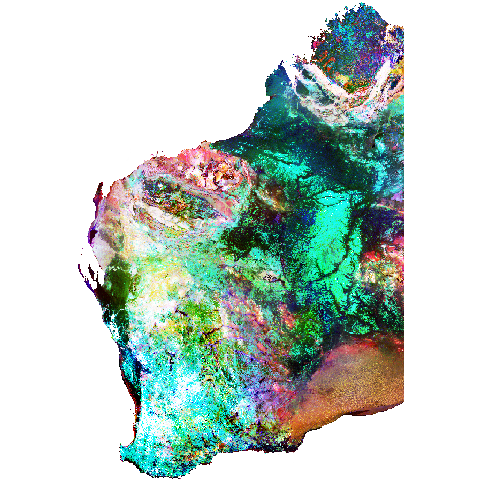

In [7]:
%%R
brick = brick('C:/Users/00097030/LocalData/Spatial Data/RADmap/Tiff/clipped/RGB_Stack.tif')
plotRGB(brick)